In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim 
import os 
import torchvision
import torchvision.transforms as transforms
from Utils import compute_comparison_matrix,save_weights, training_step, validation_step
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#hyperparameters
batch_size = 64
adam_learning_rate = 0.001
sgd_learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
sgd_epochs = 30
adam_epochs = 30


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_root = os.path.join(os.path.join('../Data/CIFAR'))

trainset = torchvision.datasets.CIFAR10(root=data_root, train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_root, train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


base_dir = os.path.join('../Data/CIFAR')

sgd_model = Net().to(device)
adam_model = sgd_model

Files already downloaded and verified
Files already downloaded and verified


In [4]:
sgd_optimizer = optim.SGD(sgd_model.parameters(), lr=sgd_learning_rate)
adam_optimizer = optim.Adam(adam_model.parameters(), lr=adam_learning_rate)

print('\nVerify initial parameters:')
for param1,param2 in zip(sgd_model.parameters(), adam_model.parameters()):
    print(torch.equal(param1,param2))


# Training and Validation Error Plots
adam_train_loss = []
adam_val_loss = []
sgd_train_loss = []
sgd_val_loss = []

print('Adam Training:\n')
for epoch in range(adam_epochs):
    adam_train_loss.append(training_step(model=adam_model, optimizer=adam_optimizer, train_loader=trainloader, device=device, criterion=criterion))
    adam_val_loss.append(validation_step(model=adam_model, val_loader=testloader, device=device, criterion=criterion))
    if epoch % 10 ==0:
        print(f'{epoch=},{adam_val_loss[epoch]=}')
    save_weights(adam_model,epoch=epoch,key='adam',base_dir=base_dir)
    
print('SGD Training:\n')
for epoch in range(sgd_epochs): 
    sgd_train_loss.append(training_step(model=sgd_model, optimizer=sgd_optimizer, train_loader=trainloader, device=device, criterion=criterion))
    sgd_val_loss.append(validation_step(model=sgd_model, val_loader=testloader, device=device, criterion=criterion))
    if epoch % 10 ==0:
        print(f'{epoch=},{sgd_val_loss[epoch]=}')
    save_weights(sgd_model,epoch=epoch,key='sgd',base_dir=base_dir)



Verify initial parameters:
True
True
True
True
True
True
True
True
True
True
Adam Training:

epoch=0,adam_val_loss[epoch]=1.3999338719495542
epoch=10,adam_val_loss[epoch]=1.1004827178207932
epoch=20,adam_val_loss[epoch]=1.188984311310349
SGD Training:

epoch=0,sgd_val_loss[epoch]=1.4096354599211627
epoch=10,sgd_val_loss[epoch]=1.5151193832895558
epoch=20,sgd_val_loss[epoch]=1.5714629508887128


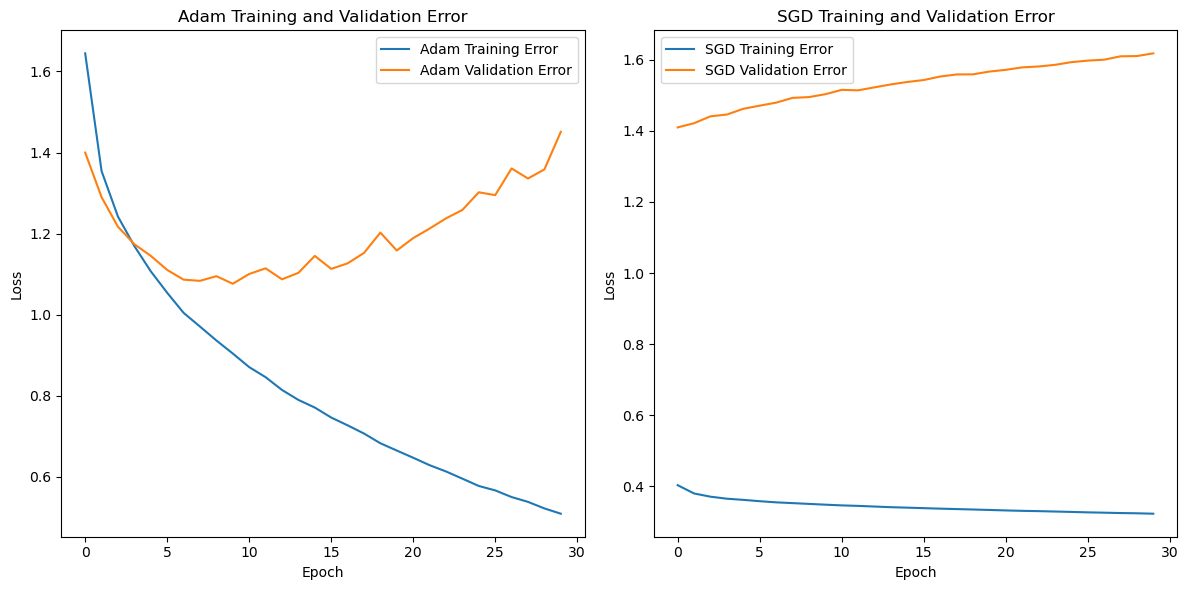

In [5]:
plt.figure(figsize=(12, 6))

# Plot Adam training and validation error
plt.subplot(1, 2, 1)
plt.plot(range(adam_epochs), adam_train_loss, label='Adam Training Error')
plt.plot(range(adam_epochs), adam_val_loss, label='Adam Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Adam Training and Validation Error')
plt.legend()

# Plot SGD training and validation error
plt.subplot(1, 2, 2)
plt.plot(range(sgd_epochs), sgd_train_loss, label='SGD Training Error')
plt.plot(range(sgd_epochs), sgd_val_loss, label='SGD Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Training and Validation Error')
plt.legend()

plt.tight_layout()
plt.show()

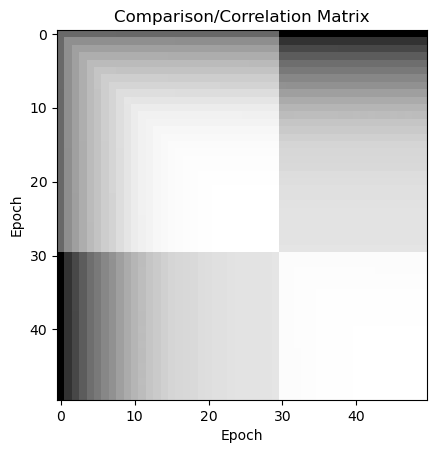

In [6]:
comparison_matrix = compute_comparison_matrix(adam_weights_dir=os.path.join(base_dir,'AdamWeights'),sgd_weights_dir=os.path.join(base_dir,'SGDWeights'))
greyscale_matrix = (comparison_matrix+1)/2
#greyscale_matrix = greyscale_matrix - greyscale_matrix.min()

plt.xlabel('Epoch')
plt.ylabel('Epoch')
plt.title('Comparison/Correlation Matrix')
plt.imshow(greyscale_matrix,cmap='gray')
plt.savefig(os.path.join('./','ComparisonMatrix.png'))